# Transfer Learning Using PyTorch Lightning ⚡️

## Setting up PyTorch Lightning

For this tutorial, we need PyTorch Lightning

In [2]:
!nvidia-smi

Sun Aug 21 07:43:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   45C    P0    56W / 150W |      0MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Завершить все процессы, использующие ГПУ в нашей ОС
!fuser -k /dev/nvidia[0]

In [1]:
import os

import pytorch_lightning as pl
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import TensorBoardLogger

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

from torchvision import transforms
from torchvision.datasets import StanfordCars
from torchvision.datasets.utils import download_url
import torchvision.models as models

Now you'll need to login to you wandb account.


## The Dataset 💿

We will be using the StanfordCars dataset to train our image classifier. It contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

In [2]:
class StanfordCarsDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Augmentation policy for training set
        self.augmentation = transforms.Compose([
            transforms.Resize(size=(224, 244)),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Preprocessing steps applied to validation and test set.
        self.transform = transforms.Compose([
            transforms.Resize(size=(224, 244)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # build dataset
        dataset = StanfordCars(
            root=self.data_dir, download=True, split="train")
        # split dataset
        self.train, self.val = random_split(dataset, [6500, 1644])

        self.test = StanfordCars(
            root=self.data_dir, download=True, split="test")

        self.test = random_split(self.test, [len(self.test)])[0]

        self.train.dataset.transform = self.augmentation
        self.val.dataset.transform = self.transform
        self.test.dataset.transform = self.transform

        self.num_classes = 196

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=12)


## LightingModule - Define the System

Let us look at the model definition to see how transfer learning can be used with PyTorch Lightning.
In the `LitModel` class, we can use the pre-trained model provided by Torchvision as a feature extractor for our classification model. Here we are using ResNet-18. A list of pre-trained models provided by PyTorch Lightning can be found here.
- When `pretrained=True`, we use the pre-trained weights; otherwise, the weights are initialized randomly.
- If `.eval()` is used, then the layers are frozen. 
- A single `Linear` layer is used as the output layer. We can have multiple layers stacked over the `feature_extractor`.

Setting the `transfer` argument to `True` will enable transfer learning.

In [3]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=1e-4, transfer=False):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes
        self.step = 0
        
        # transfer learning if pretrained=True
        self.feature_extractor = models.resnet50(pretrained=transfer)

        if transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        
        n_sizes = self._get_conv_output(input_shape)

        self.classifier = nn.Linear(n_sizes, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy()
  
    # returns the size of the output tensor going into the Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x
    
    def training_step(self, batch):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)

        acc = self.accuracy(out, gt)
        
        self.step += 1

        self.log("train_loss", loss)
        self.log("train_acc", acc)
        self.log("train_step", self.step)

        return loss
    
    def validation_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)

        self.log("val_loss", loss)

        acc = self.accuracy(out, gt)
        self.log("val_acc", acc)

        return loss
    
    def test_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)
        
        return {"loss": loss, "outputs": out, "gt": gt}
    
    def test_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        output = torch.cat([x['outputs'] for x in outputs], dim=0)
        
        gts = torch.cat([x['gt'] for x in outputs], dim=0)
        
        self.log("test_loss", loss)
        acc = self.accuracy(output, gts)
        self.log("test_acc", acc)
        
        self.test_gts = gts
        self.test_output = output
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

## Train your Model 🏋️‍♂️

### Вначале определим оптимальный learning rate для нашей модели!

In [4]:
dm = StanfordCarsDataModule(batch_size=32)
model = LitModel((3, 300, 300), 196, transfer=True)
trainer = pl.Trainer(accelerator="gpu")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# запустим процесс подбора learning rate
lr_finder = trainer.tuner.lr_find(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
`Trainer.fit` stopped: `max_steps=90` reached.
LR finder stopped early after 90 steps due to diverging loss.
Restoring states from the checkpoint path at /home/admin-gpu/Downloads/MADE_2022_contest_2/.lr_find_b93cec3f-bc82-4e72-a8c8-00a35a5dec8f.ckpt


In [6]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

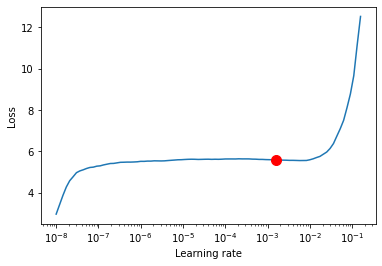

In [7]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

In [8]:
# зададим новый Lr модели
model.learning_rate = new_lr
new_lr

0.001584893192461114

### Можем найти максимально возможный батч который влезет на нашу ГПУ

Не оптимальный размер батча для обучения, а именно максимально возможный на нашем оборудовании.

In [11]:
# run batch size scaling, result overrides hparams.batch_size
dm = StanfordCarsDataModule(batch_size=32)
model = LitModel((3, 300, 300), 196, transfer=True)
trainer = pl.Trainer(accelerator="gpu", auto_scale_batch_size="binsearch")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
# call tune to find the batch size
trainer.tune(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 2 succeeded, trying batch size 4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 4 succeeded, trying batch size 8
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 8 succeeded, trying batch size 16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 16 succeeded, trying batch size 32
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 32 succeeded, trying batch size 64
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 64 succeeded, trying batch size 128
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 128 succeeded, trying batch size 256
/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 256 s

{'scale_batch_size': 2047}

### Непосредственно обучение модели

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_acc", patience=5, verbose=False, mode="max")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


In [13]:
# начинаем обучение модели
# устанавливаем желаемый размер batch'а
dm = StanfordCarsDataModule(batch_size=128)

# создаем модель
model = LitModel((3, 300, 300), 196, transfer=True)

# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | ResNet           | 25.6 M
1 | classifier        | Linear           | 196 K 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
196 K     Trainable params
25.6 M    Non-trainable params
25.8 M    Total params
103.013   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Протестируем полученную модель

In [19]:
trainer.test(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.13567964732646942
        test/loss            4.238149642944336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 4.238149642944336, 'test/acc': 0.13567964732646942}]

## Загрузим желаемый чекпоинт

In [18]:
model = model.load_from_checkpoint("lightning_logs/version_0/checkpoints/check_point-epoch=03-train_step=204.0.ckpt")

# disable randomness, dropout, etc...
model.eval()

# predict with the model
# y_hat = model(x)

LitModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

The workspace generated to compare training the model from scratch vs using transfer learning is available [here](https://wandb.ai/manan-goel/StanfordCars). The conclusions that can be drawn from this are explained in detail in [this report](https://wandb.ai/wandb/wandb-lightning/reports/Transfer-Learning-Using-PyTorch-Lightning--VmlldzoyMzMxMzk4/edit).

## Conclusion

I will encourage you to play with the code and train an image classifier with a dataset of your choice from scratch and using transfer learning. 


To learn more about transfer learning check out these resources:
- [Gotchas of transfer learning for image classification](https://docs.google.com/presentation/d/1s29WOQoQvBD5KoPUzE5TPcavjqno8ZgnZaSljHGGHVU/edit?usp=sharing) by Sayak Paul.
- [Transfer Learning with Keras and Deep Learning by PyImageSearch.](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)
- [Transfer Learning - Machine Learning's Next Frontier](https://ruder.io/transfer-learning/) by Sebastian Ruder.





